In [97]:
import torch
import torchvision
import torchvision.transforms as transforms
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)

cpu


In [98]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/cifar10_experiment_1')


In [99]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

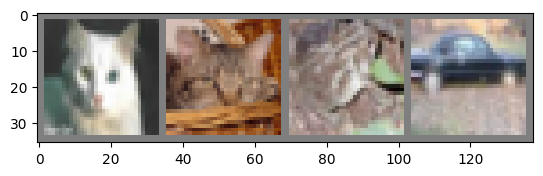

cat   cat   frog  car  


In [100]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [101]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3)  # Conv layer with 3x3 kernel, depth=8
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)  # Conv layer with 3x3 kernel, depth=16
        self.pool1 = nn.MaxPool2d(kernel_size=2)  # Max pooling with 2x2 kernel
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)  # Conv layer with 3x3 kernel, depth=32
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3)  # Conv layer with 3x3 kernel, depth=64
        self.pool2 = nn.MaxPool2d(kernel_size=2)  # Max pooling with 2x2 kernel
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)  # Fully connected with 4096 nodes
        self.fc2 = nn.Linear(4096, 1000)  # Fully connected with 1000 nodes
        self.fc3 = nn.Linear(1000, 10)  # Fully connected with 10 nodes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
dataiter = iter(trainloader)
images, labels = next(dataiter)
writer.add_graph(net, images.to(device))

In [102]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Training time:
| Device | Runtime           |
|--------|-------------------|
| CPU    | 12m 24s           |
| GPU    | 2m 8s             |

In [103]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # log the graph of the network
        if epoch == 0 and i == 0:
            writer.add_graph(net, inputs)

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            avg_loss = running_loss / 2000
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
            writer.add_scalar('training loss', avg_loss, epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.292
[1,  4000] loss: 2.061
[1,  6000] loss: 1.843
[1,  8000] loss: 1.687
[1, 10000] loss: 1.575
[1, 12000] loss: 1.472
[2,  2000] loss: 1.371
[2,  4000] loss: 1.336
[2,  6000] loss: 1.260
[2,  8000] loss: 1.186
[2, 10000] loss: 1.118
[2, 12000] loss: 1.110
Finished Training


In [104]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

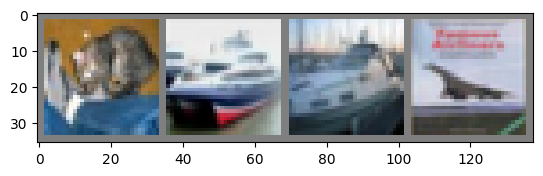

GroundTruth:  cat   ship  ship  plane


In [105]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [106]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  car   ship 


In [107]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # get the top 3 predictions
        _, top3_predicted = torch.topk(outputs, 3, dim=1)
        total += labels.size(0)
        # check if the true label is in the top 3 predictions
        correct += sum(labels[j] in top3_predicted[j] for j in range(labels.size(0)))

print(f'Accuracy of the network on the 10000 test images (top-3): {100 * correct // total} %')

Accuracy of the network on the 10000 test images (top-3): 89 %


In [108]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
wrong_examples = []
wrong_labels = []
wrong_top3 = []

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, top3_predicted = torch.topk(outputs, 3, dim=1)
        # collect the correct predictions for each class
        for img, label, top3 in zip(images, labels, top3_predicted):
            if label in top3:
                correct_pred[classes[label]] += 1
            else:
                wrong_examples.append(img.cpu())
                wrong_labels.append(label.cpu())
                wrong_top3.append(top3.cpu())
            total_pred[classes[label]] += 1

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Accuracy for class: plane is 89.5 %
Accuracy for class: car   is 95.4 %
Accuracy for class: bird  is 75.8 %
Accuracy for class: cat   is 85.6 %
Accuracy for class: deer  is 93.6 %
Accuracy for class: dog   is 89.9 %
Accuracy for class: frog  is 90.4 %
Accuracy for class: horse is 84.9 %
Accuracy for class: ship  is 91.9 %
Accuracy for class: truck is 94.1 %


In [109]:
import random

# Randomly select 5 wrong examples
selected_indices = random.sample(range(len(wrong_examples)), min(5, len(wrong_examples)))
selected_images = [wrong_examples[i] for i in selected_indices]
selected_labels = [wrong_labels[i] for i in selected_indices]
selected_top3 = [wrong_top3[i] for i in selected_indices]

for i, (img, label, top3) in enumerate(zip(selected_images, selected_labels, selected_top3)): 
    img = img / 2 + 0.5 # Unnormalize for display 
    top3_labels = ', '.join([classes[pred] for pred in top3])
    writer.add_image(f'Wrong Example {i+1} | True label: {classes[label]} | Predicted top 3: {top3_labels}', torchvision.utils.make_grid(img), global_step=i)


In [110]:
%load_ext tensorboard
%tensorboard --logdir=runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 6542), started 1:17:31 ago. (Use '!kill 6542' to kill it.)